# A Brief Introduction to Graph Convolutional Networks (GCN)


## Graphs

We can define a graph as a picture that represent the data in an organised manner. Let's go deep into applied graph theory. A graph(being directed or undirected) consists of set of vertices(or nodes) denoted by V and a set of edges denoted by E. Edges can be weighted or binary. Let's have a look of a graph. 

![img](graph2.png)


In the above graph we have:- V={A,B,C,D,E,F,G} E={(A,B),(B,C),(C,E),(B,D),(E,F),(D,E),(B,E),(G,E)} Above all these edges their corresponding weights have been specified. These weights can represent different quantities.For example if we consider these nodes as different cities, edges can be the distance between these cities.

## Terminology

 - __Node__ : A node is a person in the graph. Every person has a corresponding node and every node corresponds to one person. It is represented  by circles in the graph.
 - __Edge__ : It is the line joining two nodes in a graph. Presence of an edge between two nodes indices that the two nodes have interacted with each other. It is represented by straight lines in the graph.
 - __Degree of a vertex__ -The degree of a vertex V of a graph G (denoted by deg (V)) is the number of edges incident with the vertex V. As an instance consider node B, it has 3 outgoing edges and 1 incoming edge, so outdegree is 3 and indegree is 1.

 - __Adjacency Matrix__ : It is a method of representing a graph using only a square Matrix. Suppose there are N nodes there in a graph then there will be N rows and N columns in the corresponding adjacency matrix. The i'th row will contain a 1 in the j'th column if there is an edge between the i'th and the j'th node otherwise it will contain a 0.
 ![img](adj_mat.jpg)
 
 

## What is GCN

If we look around us, what we observe is that most of the real-world datasets come in the form of graphs or networks: social networks, protein-interaction networks, the World Wide Web, etc. As the name suggests, Graph Convolution Networks (GCN), draw on the idea of Convolution Neural Networks re-defining them for the graph domain. As we know a regular convolutional neural network captures the surrounding information of each pixel of an image. As for images, the convolution framework aims to capture neighbourhood information for graph nodes also.

GCN is basically a neural network that operates on a graph. It will take a graph as an input and give some meaningful output. It is a very powerful method that can work on a large number of graphs with very little about of human help. Even if the information about only 2 nodes is given it can predict for the graph with very high accuracy rate. 

GCNs come in two varieties: Spectral GCNs and Spatial GCNs.Spectral-based approaches define graph convolutions by introducing filters from the perspective of graph signal processing which is based on graph spectral theory. Spatial-based approaches formulate graph convolutions as aggregating feature information from neighbours.

Spectral approach has the limitation of the graph structure being same for all samples i.e. homogeneous structure. But it is a hard constraint, as most of the real-world graph data has different structures and size for different samples i.e. heterogeneous structure. On the other hand we have spatial approach which does not require homogeneous graph structure.



### A simple example

One possible application of GCN is in the Facebook's friend prediction algorithm. Consider three people A, B and C. Given that A is a friend of B, B is a friend of C. You are also given some information about each person, now you have to predict whether A is friend of C. Today we will be discussing about a simpler version of this problem.

Now first I will show you a very simple method for predicting the Friend Prediction problem and then we will generalize this to work with much better success rate.

#### Problem Statement: You are given N persons and also a graph where there is an edge between two people if they are friends.  Now you have to predict whether two persons will become friend in future or not.

A simple graph corresponding to this problem is:
![img](friends_graph.png)
Here person (1,2) are friends, similarly (2,3), (3,4), (4,1), (5,6),(6,8), (8,7), (7,6) are also friends.

Now we are interested in finding out whether a given pair of person will become friend in future or not. Lets say that the pair we are interested in in (1,3), now since they have 2 common friends implies they have a high chance of becoming friends, whereas the node (1,5) have no friend in common so they are much less likely to become friends.

Lets take another example:
![img](friends_graph2.png)
Here (1,11) are much more likely to become friends than say (3, 11).

So we can say that nodes that are closer are much more likely to be similar than the nodes that are far from each other.

Now the next question that arises is 'How to implement this?'. GCN's implement it in a way similar to CNNs. In CNN we apply a filter on the original image to get the representation in next layer. Similarly in GCN we apply a filter which creates the next layer representation. Mathematically, 
                            __H(l+1)=f(A, H(l)) where A is the adjacency matrix__
A very simple example of f is
                            __f(A, H(l),X)=RELU( A*H(l)*W(l))__

But in this we will be facing two major problems:
 - Value of node is not a function of its previous value : As you can see the value of a node is only a function of its neighbours but not of the node itself. We can overcome this by adding self loops, that is an edge starting and ending on the same node, in this way a node will become a neighbour of itself.
 - Nodes that have large number of neighbours will get much more input from them and hence will have a large value, and this value will grow very fast. To deal with this we will be using normalisation ,i.e, reduce all values in such a way that the values dont explode.


In this tutorial we will be using the following choices of 'f' functions.
                    __output = sigmoid( A_hat * RELU( A_hat * X * W(0) ) * W(1)), where A_hat= D^(-0.5) *(A+I) *D^(-0.5)__ , [https://arxiv.org/pdf/1901.00596.pdf
                    ]
                    

# Implementing GCN in PyTorch

We are now ready to put all of the tools together to deploy your first fully-functional Graph Convolutional network. In this tutorial we will be using GCN on the 'Zachary karate club network'. We will be using the 'Semi Supervised Graph Learning Model' proposed in ------.



### Zachary Karate Club

During the period from 1970-1972, Wayne W. Zachary, observed the people belonging to a local karate club. He represented these people as nodes in a graph. And added a edge between a pair of people if they interacted with each other. The result was a the graph shown below.
![img](karate_club.png)

During the study an interesting event happened. A conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. 

Using the graph that he had found earlier, he tried to predict which member will go to which half. And surprisingly he was able to predict the decision of all the members except for node 9 who went with Mr. Hi instead of John A. Zachary used the maximum flow – minimum cut Ford–Fulkerson algorithm for this. We will be using a different algorithm today, hence it is not required to know about Ford-Fulkerson algorithm.

Here we will be using the Semi Supervised Graph Learning Method. Semi Supervised means that we have labels for only some of the nodes and we have find the labels for other nodes. Like in this example we have the labels for only the nodes belonging to 'John A' and 'Mr. Hi', we have not been provided with labels for any other member and we have be predict that only on the basis of the graph given to us.

### Loading Required Libraries
In this post we will be using PyTorch and Matplotlib.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import imageio

### The Convolutional Layer
First we will be creating the GCNConv class, which will serve as the Layer creation class. Every instance of this class will be getting Adjacency Matrix as input and will be outputing 'RELU(A_hat * X * W)', which the Net class will use.

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat=A+torch.eye(A.size(0))
        self.D=torch.diag(torch.sum(A,1))
        self.D=self.D.inverse().sqrt()
        self.A_hat=torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W=nn.Parameter(torch.rand(in_channels,out_channels, requires_grad=True))
    def forward(self, X):
        out=torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out

The Net  class will combine multiple Conv layer.

In [3]:

class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):

        super(Net, self).__init__()
        self.conv1=GCNConv(A,nfeat, nhid)
        self.conv2=GCNConv(A,nhid, nout)
        
    def forward(self,X):
        H=self.conv1(X)
        H2=self.conv2(H)
        return H2
        


'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.

In [4]:
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])



In this example we have the label for admin(node 1) and instructor(node 34) so only these two contain the class label(0 and 1) all other are set to -1, which means that the predicted value of these nodes will be ignores in the computation of loss function.

In [5]:
target=torch.tensor([0,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,1])

X is the feature matrix. Since we dont have any feature of each node, we will just be using the one-hot encoding corresponding to the index of the node.

In [6]:
X=torch.eye(A.size(0))

Here we are creating a Network with 10 features in the hidden layer and 2 in output layer.

In [7]:
T=Net(A,X.size(0), 10, 2)

### Training

In [8]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.01, momentum=0.9)

In [9]:
loss=criterion(T(X),target)


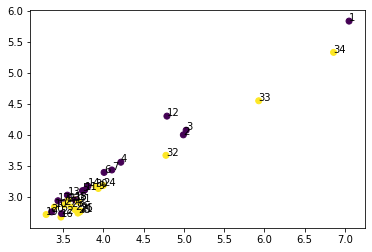

Cross Entropy Loss: = 1.0214941501617432


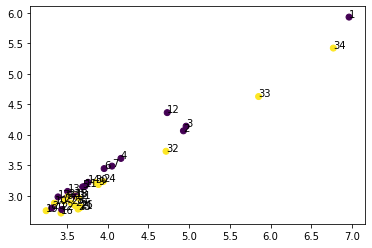

Cross Entropy Loss: = 0.9919909238815308


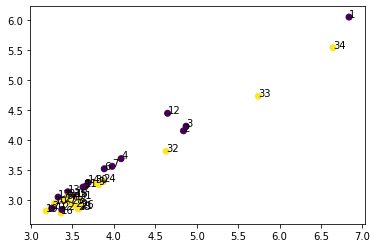

Cross Entropy Loss: = 0.9415945410728455


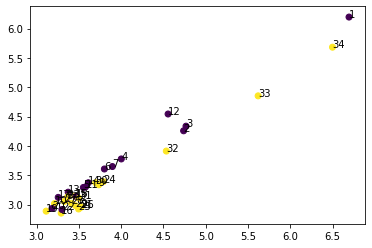

Cross Entropy Loss: = 0.8826035261154175


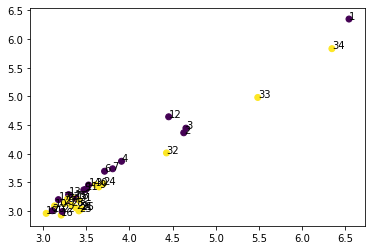

Cross Entropy Loss: = 0.8286798596382141


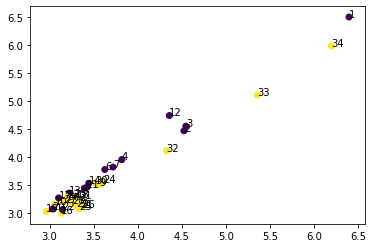

Cross Entropy Loss: = 0.7912701368331909


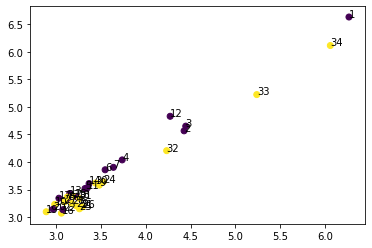

Cross Entropy Loss: = 0.7756771445274353


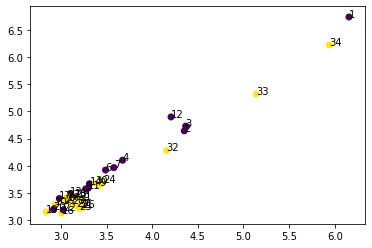

Cross Entropy Loss: = 0.779295802116394


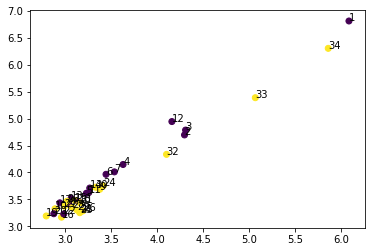

Cross Entropy Loss: = 0.7936190366744995


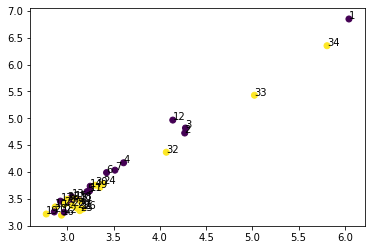

Cross Entropy Loss: = 0.8085384368896484


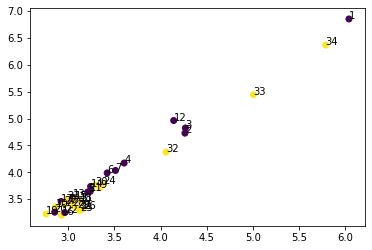

Cross Entropy Loss: = 0.8160961270332336


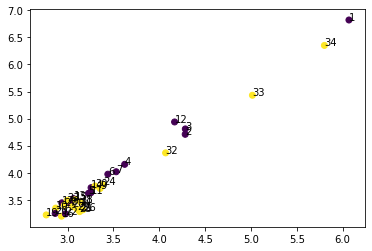

Cross Entropy Loss: = 0.8122832775115967


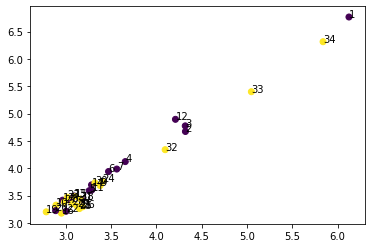

Cross Entropy Loss: = 0.797140896320343


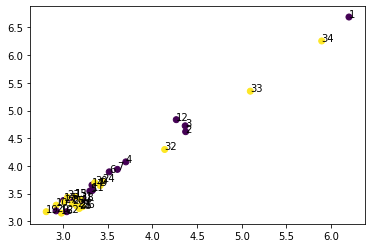

Cross Entropy Loss: = 0.7738943099975586


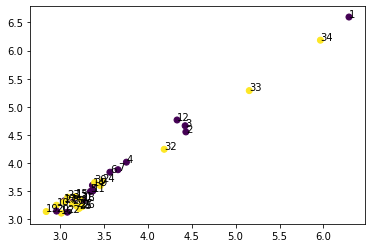

Cross Entropy Loss: = 0.7475842833518982


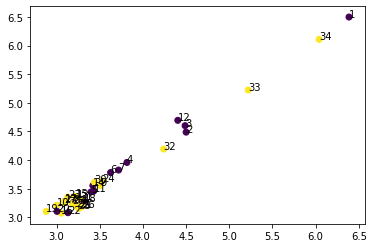

Cross Entropy Loss: = 0.7234303951263428


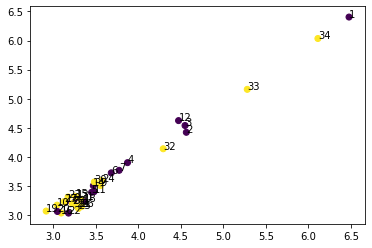

Cross Entropy Loss: = 0.7052528858184814


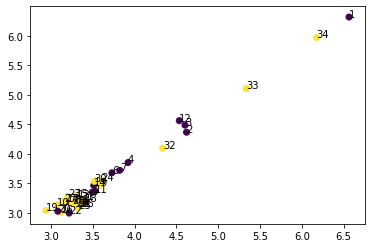

Cross Entropy Loss: = 0.6944394707679749


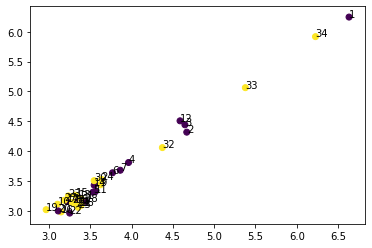

Cross Entropy Loss: = 0.6898667216300964


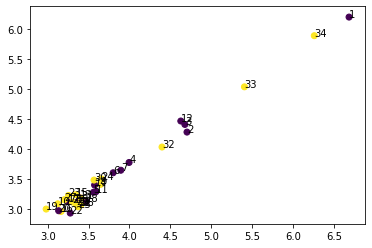

Cross Entropy Loss: = 0.6887400150299072


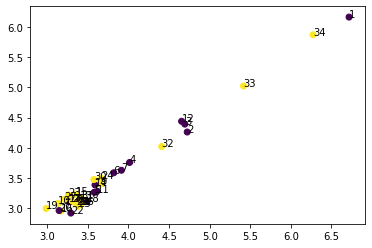

Cross Entropy Loss: = 0.68784499168396


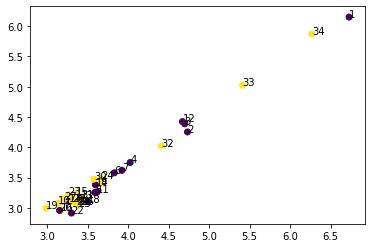

Cross Entropy Loss: = 0.6846331357955933


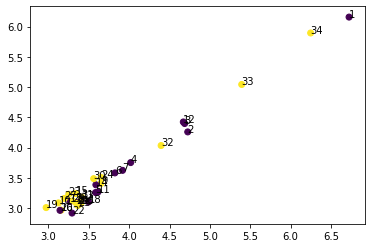

Cross Entropy Loss: = 0.677821934223175


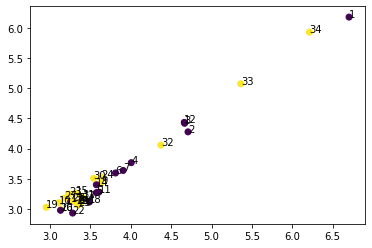

Cross Entropy Loss: = 0.6674822568893433


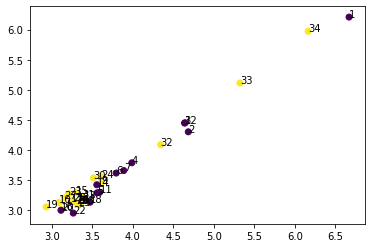

Cross Entropy Loss: = 0.6547418832778931


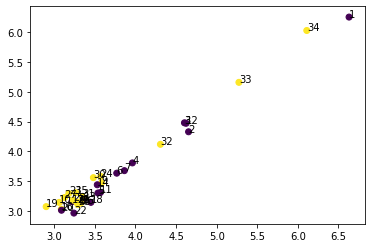

Cross Entropy Loss: = 0.6412696838378906


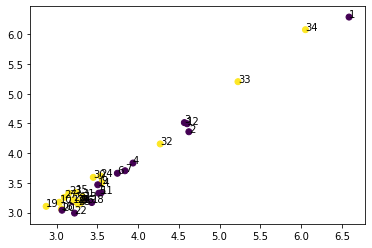

Cross Entropy Loss: = 0.628693699836731


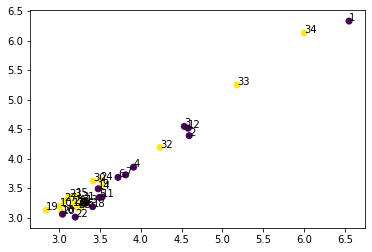

Cross Entropy Loss: = 0.6181217432022095


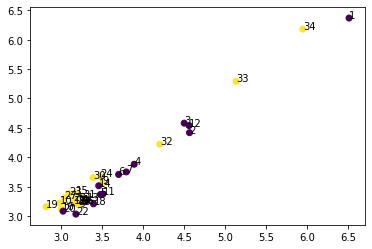

Cross Entropy Loss: = 0.6098877787590027


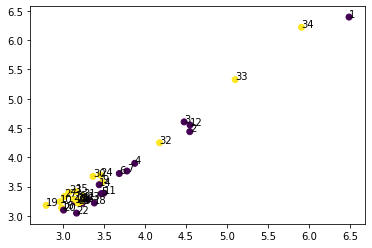

Cross Entropy Loss: = 0.6035761833190918


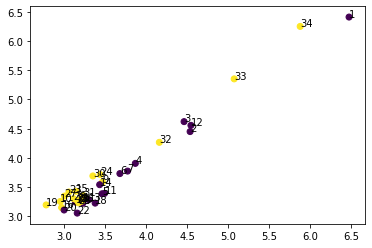

Cross Entropy Loss: = 0.5982869267463684


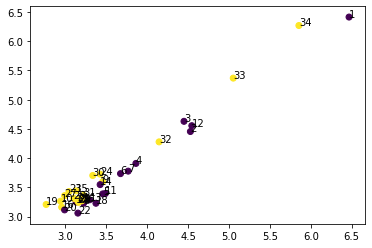

Cross Entropy Loss: = 0.5930028557777405


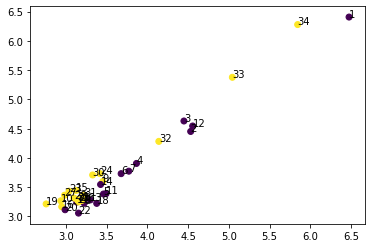

Cross Entropy Loss: = 0.5869213342666626


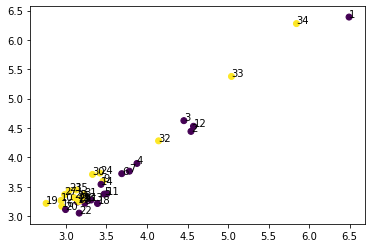

Cross Entropy Loss: = 0.5796513557434082


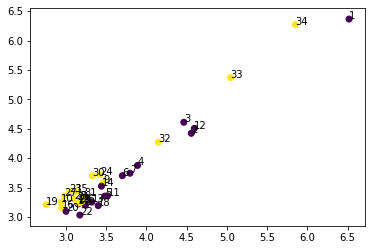

Cross Entropy Loss: = 0.5712445378303528


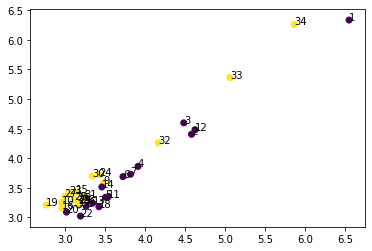

Cross Entropy Loss: = 0.5620905756950378


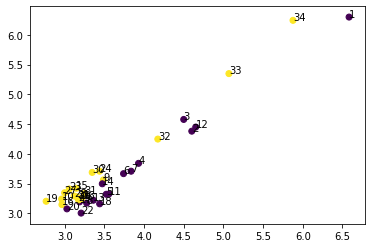

Cross Entropy Loss: = 0.5527307987213135


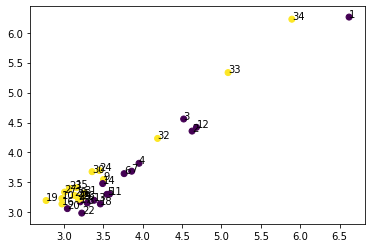

Cross Entropy Loss: = 0.5436654090881348


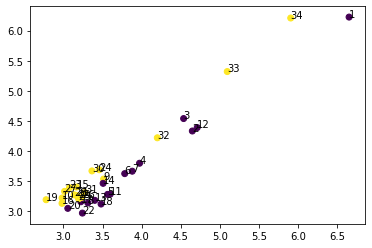

Cross Entropy Loss: = 0.5352059602737427


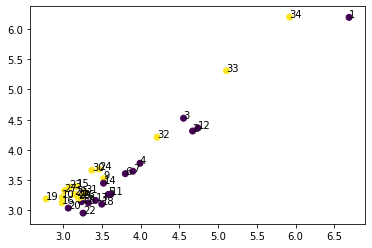

Cross Entropy Loss: = 0.5274189710617065


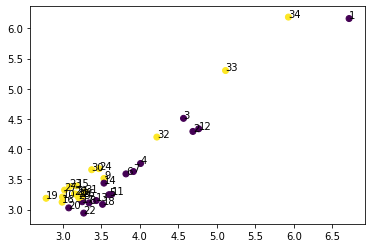

Cross Entropy Loss: = 0.5201511383056641


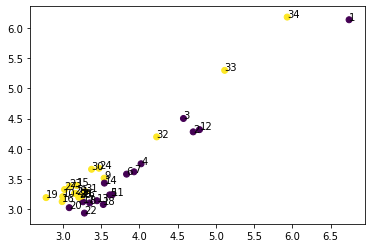

Cross Entropy Loss: = 0.5131184458732605


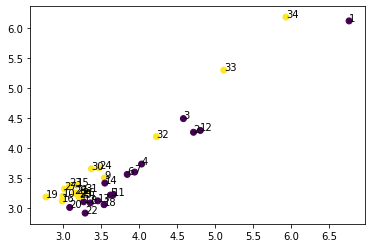

Cross Entropy Loss: = 0.5060181617736816


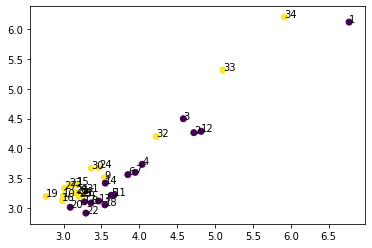

Cross Entropy Loss: = 0.4986174702644348


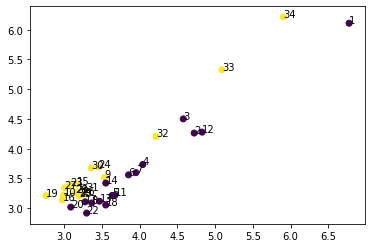

Cross Entropy Loss: = 0.49080997705459595


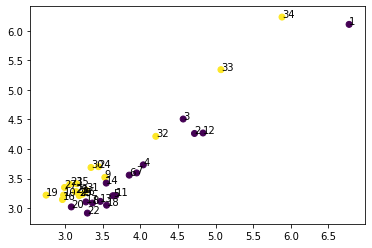

Cross Entropy Loss: = 0.4826172888278961


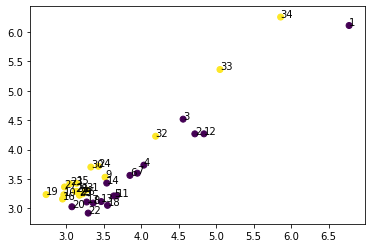

Cross Entropy Loss: = 0.4741581082344055


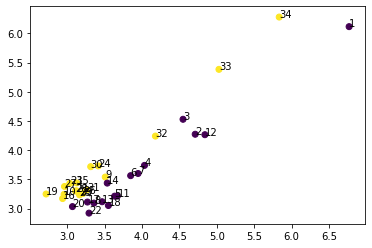

Cross Entropy Loss: = 0.4655928611755371


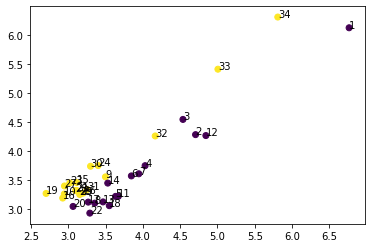

Cross Entropy Loss: = 0.457070529460907


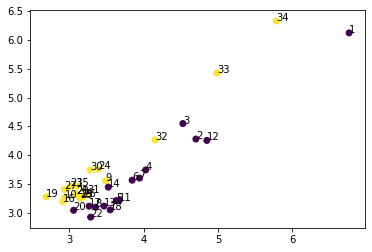

Cross Entropy Loss: = 0.44868725538253784


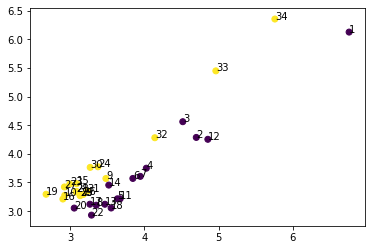

Cross Entropy Loss: = 0.44047078490257263


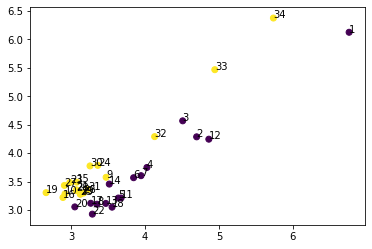

Cross Entropy Loss: = 0.43238744139671326


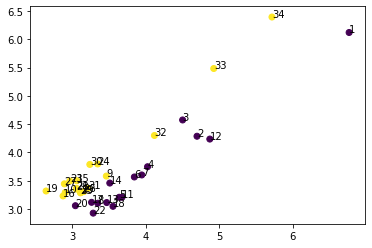

Cross Entropy Loss: = 0.4243648648262024


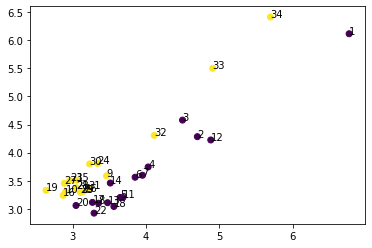

Cross Entropy Loss: = 0.41632264852523804


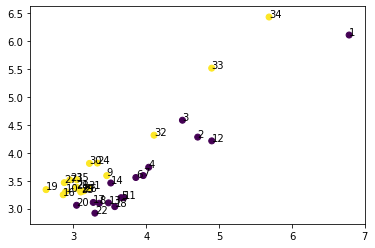

Cross Entropy Loss: = 0.408197820186615


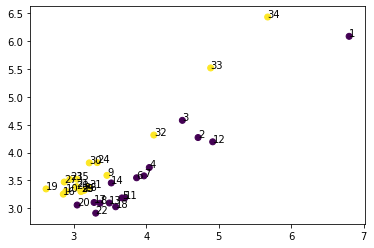

Cross Entropy Loss: = 0.3999597728252411


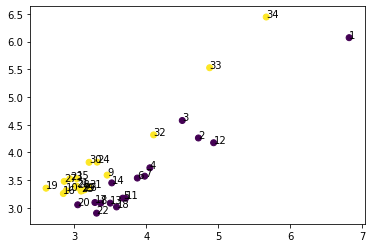

Cross Entropy Loss: = 0.39161568880081177


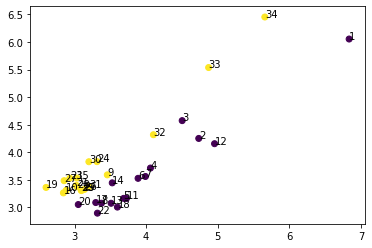

Cross Entropy Loss: = 0.38319939374923706


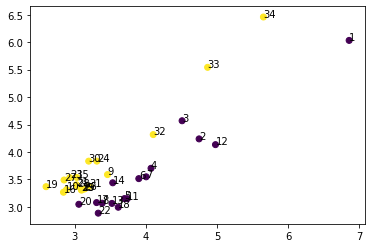

Cross Entropy Loss: = 0.3747609257698059


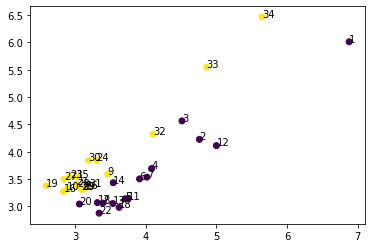

Cross Entropy Loss: = 0.366349458694458


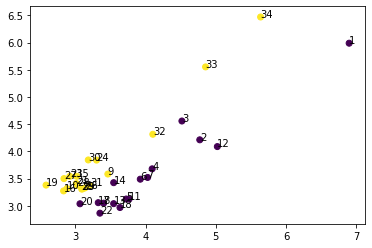

Cross Entropy Loss: = 0.3580026626586914


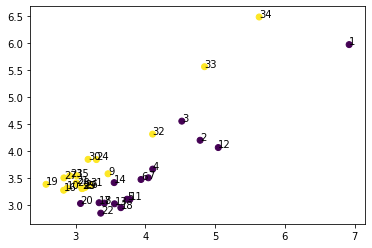

Cross Entropy Loss: = 0.3497416377067566


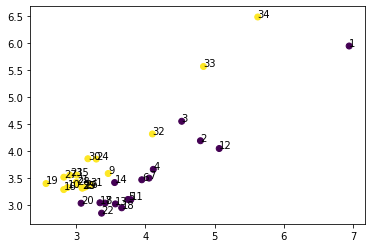

Cross Entropy Loss: = 0.3415711224079132


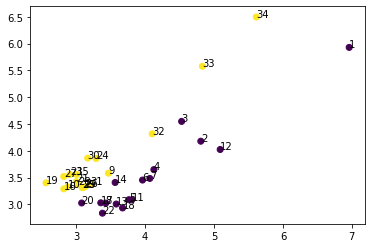

Cross Entropy Loss: = 0.33348333835601807


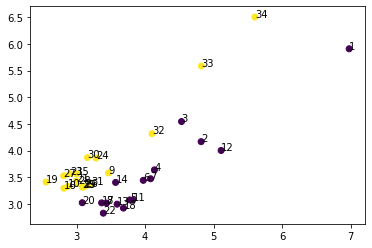

Cross Entropy Loss: = 0.3254657983779907


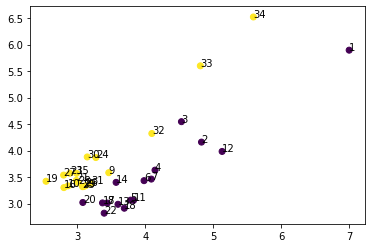

Cross Entropy Loss: = 0.3175075650215149


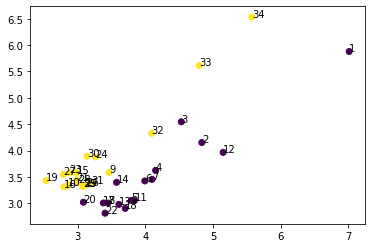

Cross Entropy Loss: = 0.3096030354499817


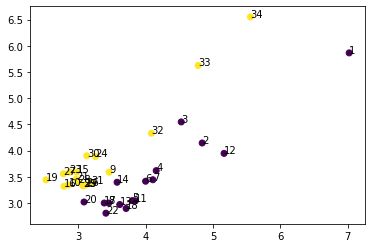

Cross Entropy Loss: = 0.3017558455467224


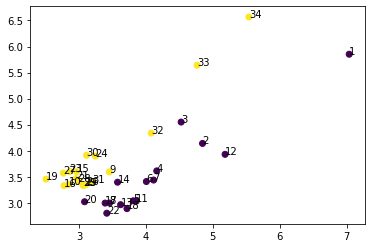

Cross Entropy Loss: = 0.29397594928741455


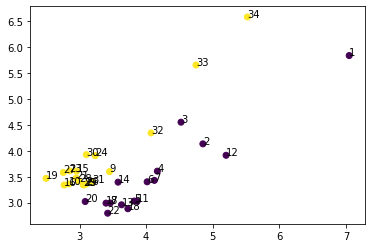

Cross Entropy Loss: = 0.28627824783325195


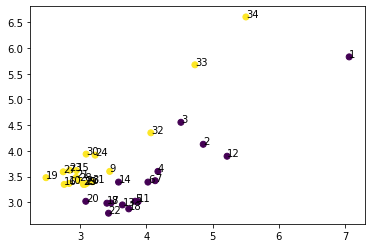

Cross Entropy Loss: = 0.27867990732192993


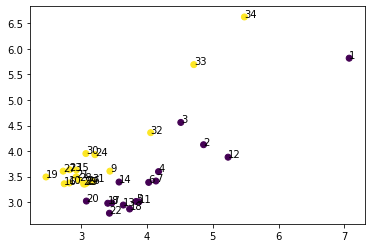

Cross Entropy Loss: = 0.27119630575180054


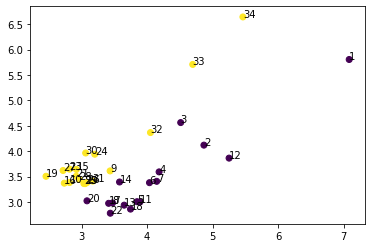

Cross Entropy Loss: = 0.26384055614471436


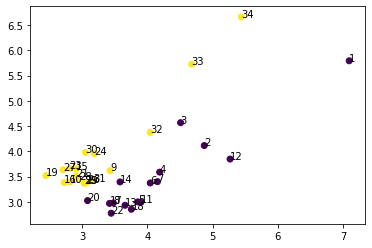

Cross Entropy Loss: = 0.256621778011322


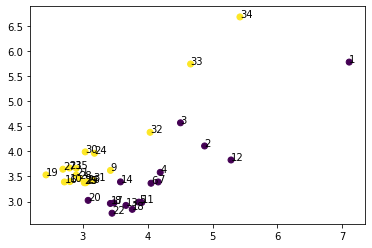

Cross Entropy Loss: = 0.2495446801185608


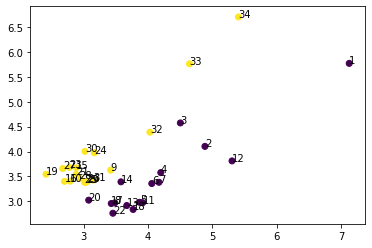

Cross Entropy Loss: = 0.24261170625686646


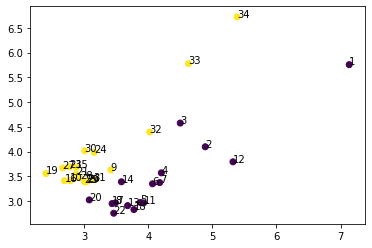

Cross Entropy Loss: = 0.23582318425178528


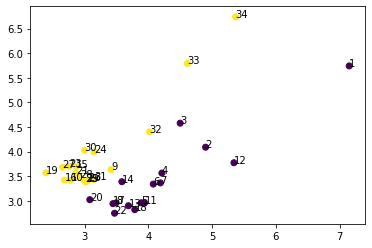

Cross Entropy Loss: = 0.22917935252189636


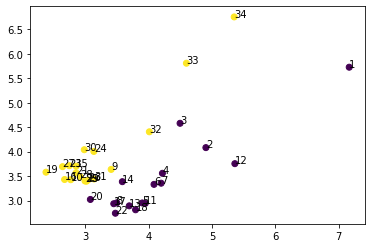

Cross Entropy Loss: = 0.2226804941892624


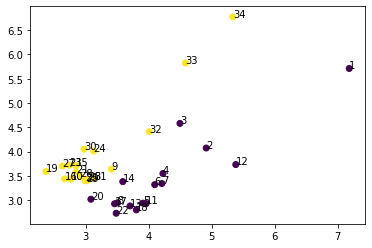

Cross Entropy Loss: = 0.2163277119398117


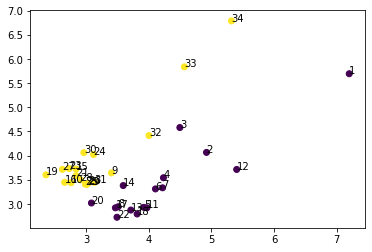

Cross Entropy Loss: = 0.21012301743030548


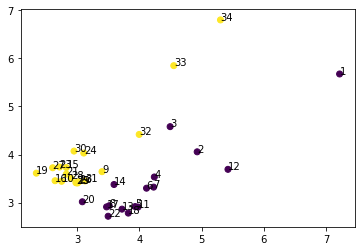

Cross Entropy Loss: = 0.2040691375732422


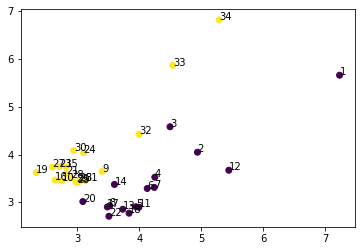

Cross Entropy Loss: = 0.19816875457763672


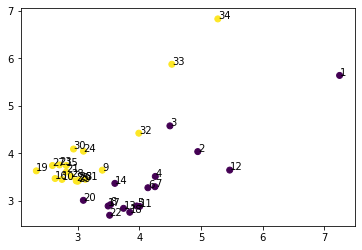

Cross Entropy Loss: = 0.1924242079257965


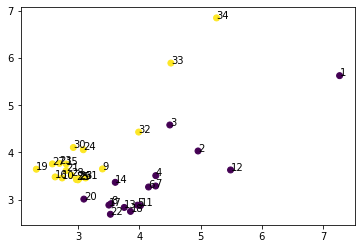

Cross Entropy Loss: = 0.18683762848377228


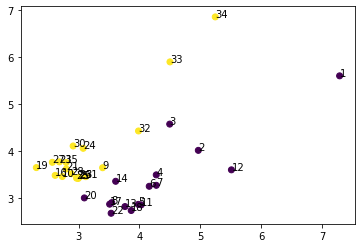

Cross Entropy Loss: = 0.18140968680381775


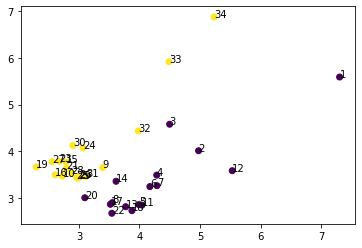

Cross Entropy Loss: = 0.1761624664068222


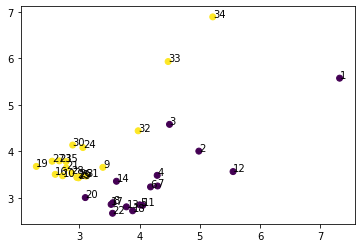

Cross Entropy Loss: = 0.17108209431171417


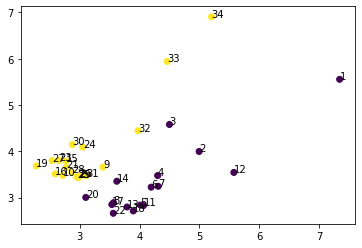

Cross Entropy Loss: = 0.16615763306617737


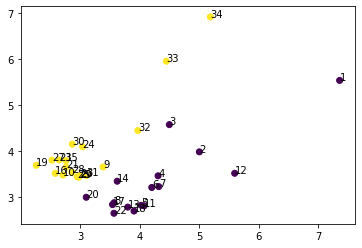

Cross Entropy Loss: = 0.16138657927513123


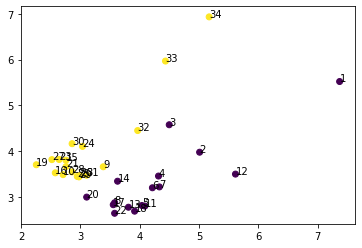

Cross Entropy Loss: = 0.15676631033420563


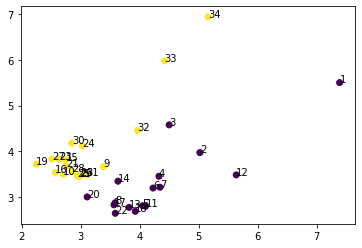

Cross Entropy Loss: = 0.15229377150535583


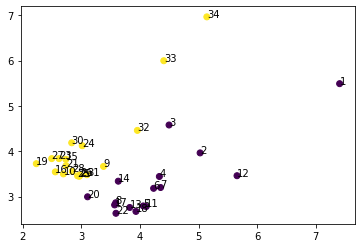

Cross Entropy Loss: = 0.14796608686447144


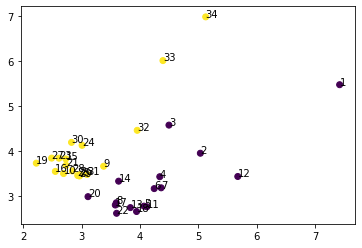

Cross Entropy Loss: = 0.14378012716770172


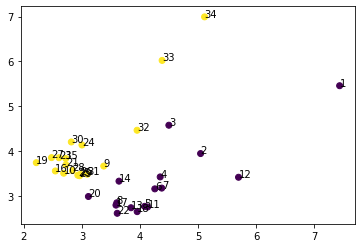

Cross Entropy Loss: = 0.1397327184677124


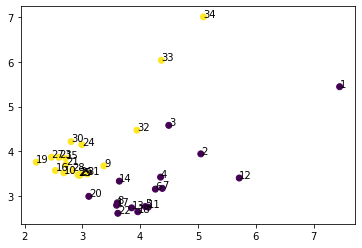

Cross Entropy Loss: = 0.13582079112529755


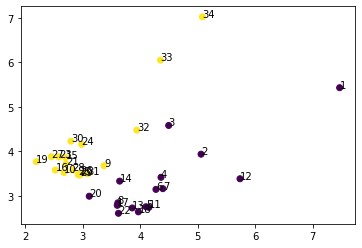

Cross Entropy Loss: = 0.13204103708267212


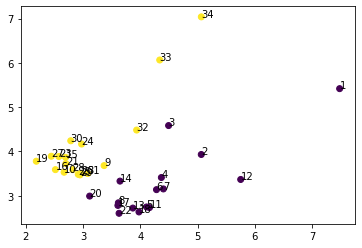

Cross Entropy Loss: = 0.128390371799469


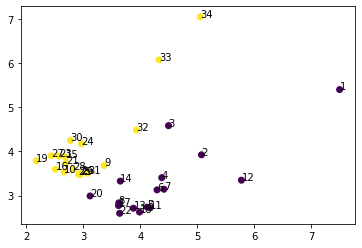

Cross Entropy Loss: = 0.12486550211906433


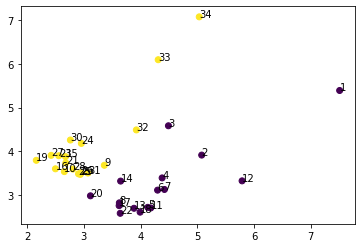

Cross Entropy Loss: = 0.12146277725696564


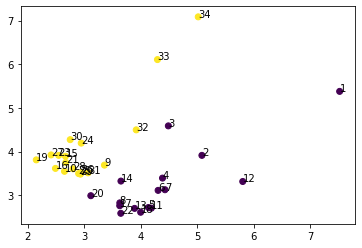

Cross Entropy Loss: = 0.11819079518318176


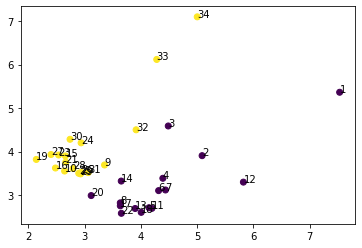

Cross Entropy Loss: = 0.11504025757312775


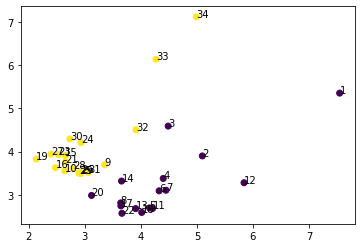

Cross Entropy Loss: = 0.11200079321861267


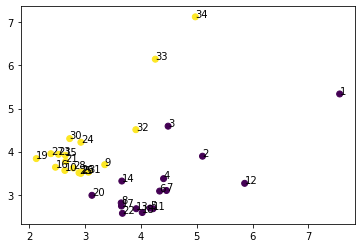

Cross Entropy Loss: = 0.10906863212585449


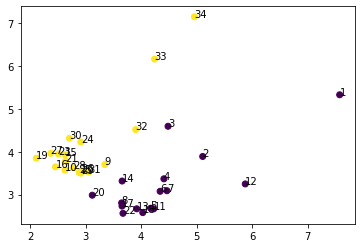

Cross Entropy Loss: = 0.1062401831150055


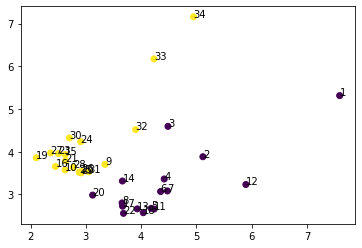

Cross Entropy Loss: = 0.10351181030273438


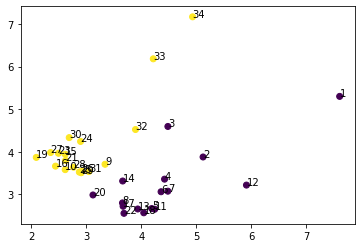

Cross Entropy Loss: = 0.10088007152080536


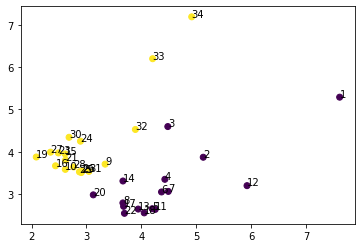

Cross Entropy Loss: = 0.09834147989749908


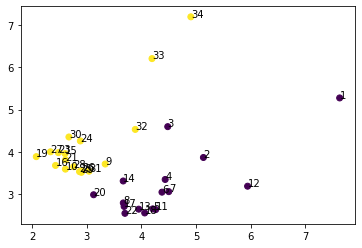

Cross Entropy Loss: = 0.09589250385761261


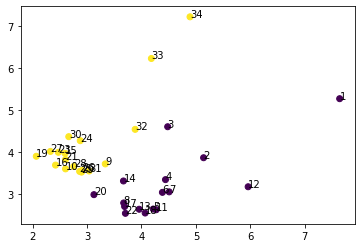

Cross Entropy Loss: = 0.09352993965148926


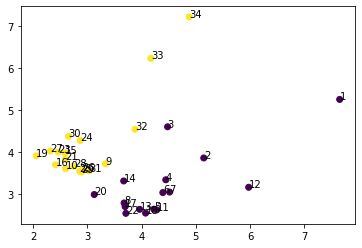

Cross Entropy Loss: = 0.09125039726495743


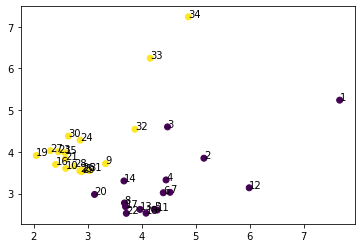

Cross Entropy Loss: = 0.08905097842216492


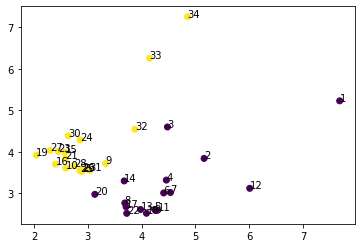

Cross Entropy Loss: = 0.0869285836815834


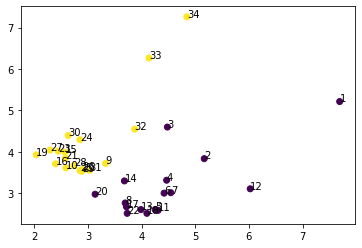

Cross Entropy Loss: = 0.08488031476736069


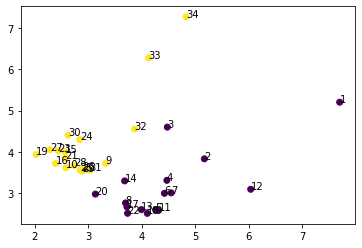

Cross Entropy Loss: = 0.08290314674377441


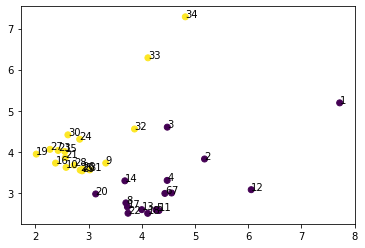

Cross Entropy Loss: = 0.08099454641342163


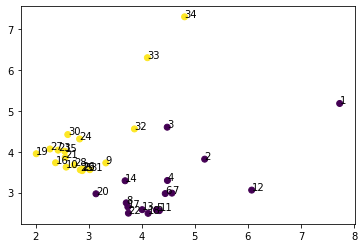

Cross Entropy Loss: = 0.07915176451206207


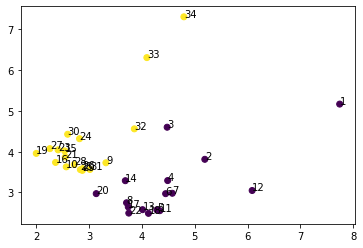

Cross Entropy Loss: = 0.0773722231388092


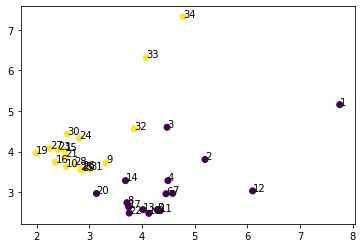

Cross Entropy Loss: = 0.07565349340438843


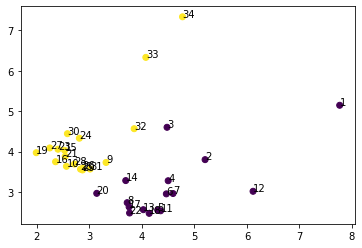

Cross Entropy Loss: = 0.07399630546569824


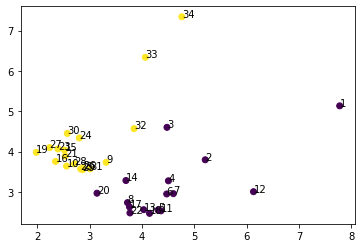

Cross Entropy Loss: = 0.07240156829357147


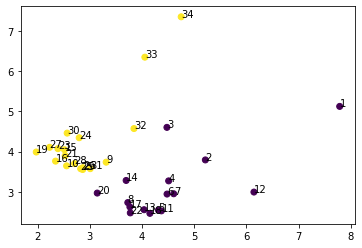

Cross Entropy Loss: = 0.07086064666509628


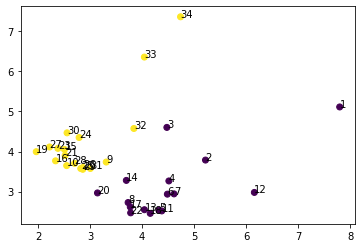

Cross Entropy Loss: = 0.06937135010957718


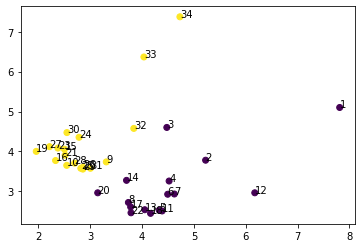

Cross Entropy Loss: = 0.06793157011270523


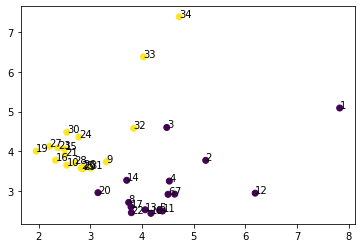

Cross Entropy Loss: = 0.06653924286365509


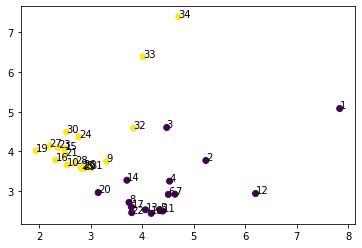

Cross Entropy Loss: = 0.06519243866205215


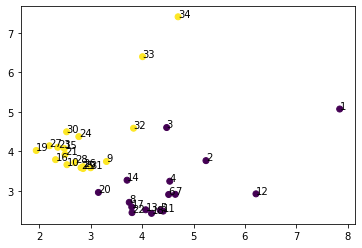

Cross Entropy Loss: = 0.06388933956623077


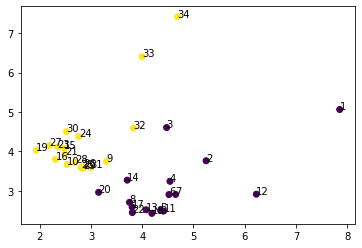

Cross Entropy Loss: = 0.06262820959091187


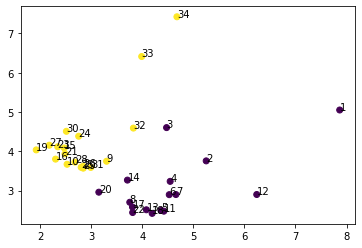

Cross Entropy Loss: = 0.061407193541526794


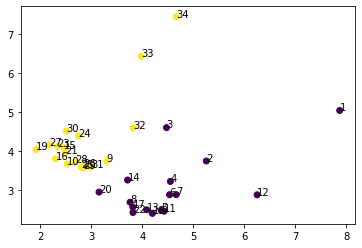

Cross Entropy Loss: = 0.060224875807762146


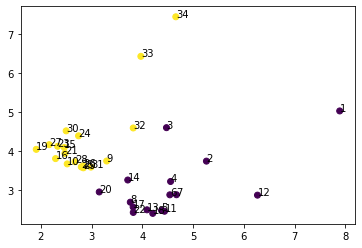

Cross Entropy Loss: = 0.05907953158020973


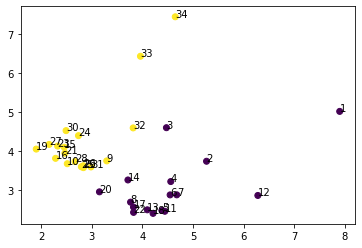

Cross Entropy Loss: = 0.057969830930233


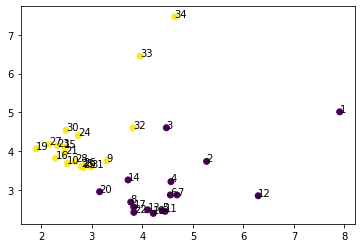

Cross Entropy Loss: = 0.05689431354403496


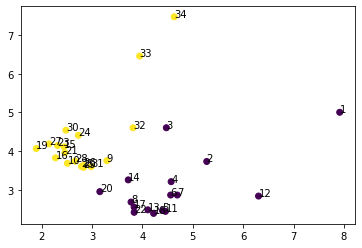

Cross Entropy Loss: = 0.05585157126188278


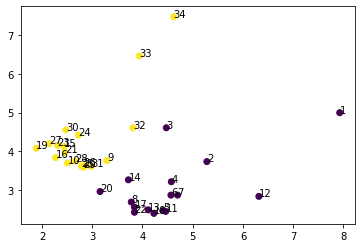

Cross Entropy Loss: = 0.05484035611152649


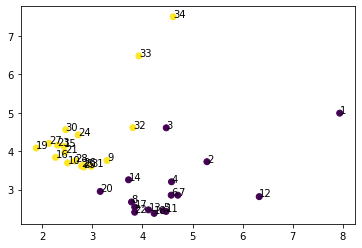

Cross Entropy Loss: = 0.05385945737361908


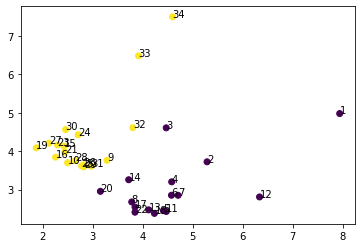

Cross Entropy Loss: = 0.05290767550468445


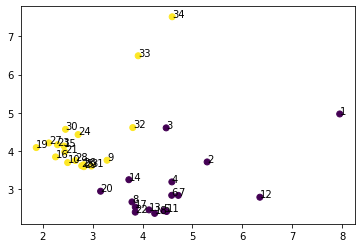

Cross Entropy Loss: = 0.0519837848842144


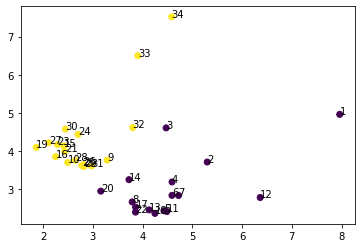

Cross Entropy Loss: = 0.0510869026184082


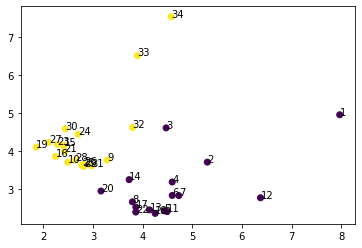

Cross Entropy Loss: = 0.050215914845466614


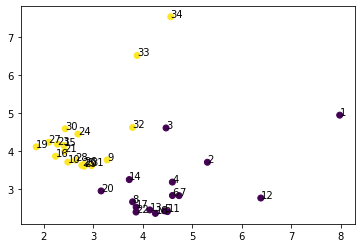

Cross Entropy Loss: = 0.04936980456113815


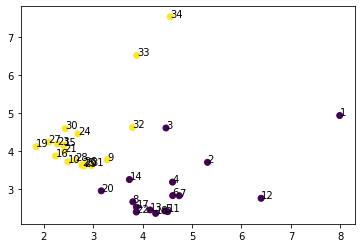

Cross Entropy Loss: = 0.04854762554168701


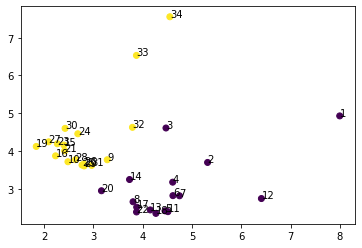

Cross Entropy Loss: = 0.04774856939911842


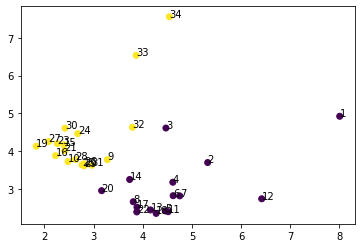

Cross Entropy Loss: = 0.046971626579761505


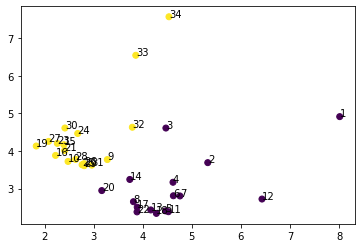

Cross Entropy Loss: = 0.046216100454330444


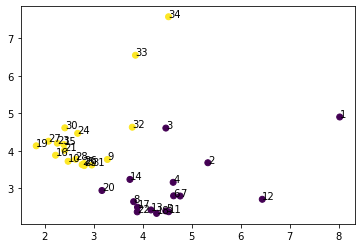

Cross Entropy Loss: = 0.04548124223947525


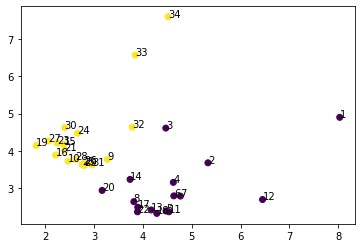

Cross Entropy Loss: = 0.0447661355137825


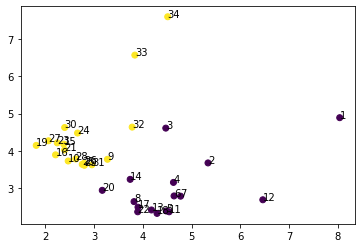

Cross Entropy Loss: = 0.04407024383544922


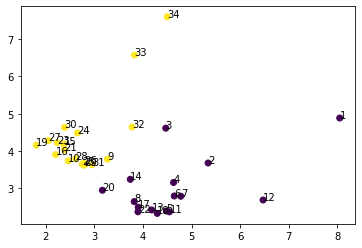

Cross Entropy Loss: = 0.04339264705777168


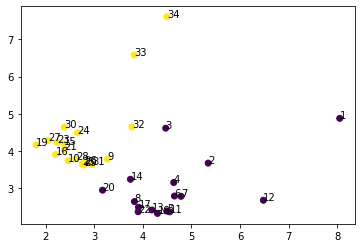

Cross Entropy Loss: = 0.042732976377010345


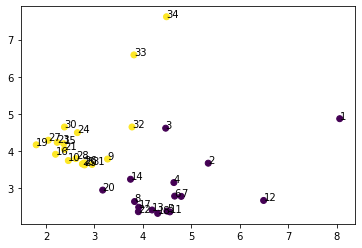

Cross Entropy Loss: = 0.04209030047059059


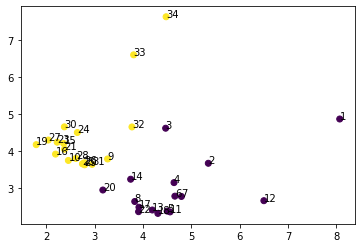

Cross Entropy Loss: = 0.04146425053477287


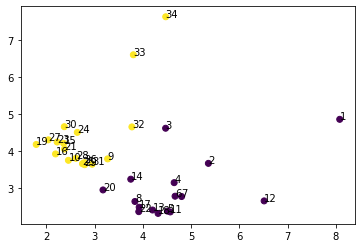

Cross Entropy Loss: = 0.04085417091846466


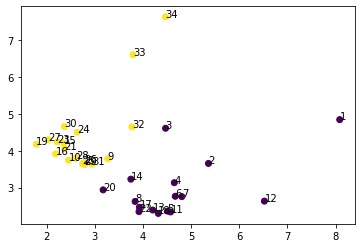

Cross Entropy Loss: = 0.040259405970573425


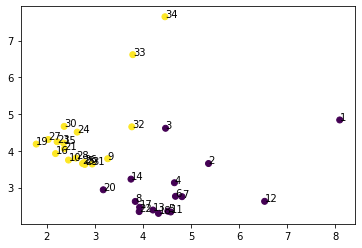

Cross Entropy Loss: = 0.0396796353161335


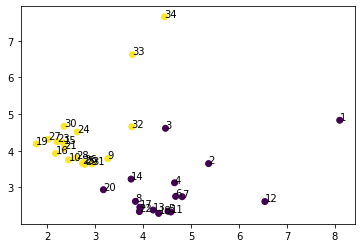

Cross Entropy Loss: = 0.03911420330405235


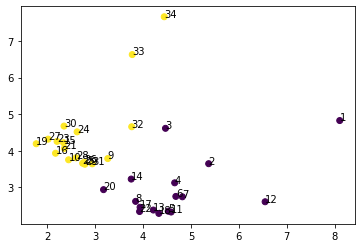

Cross Entropy Loss: = 0.03856261447072029


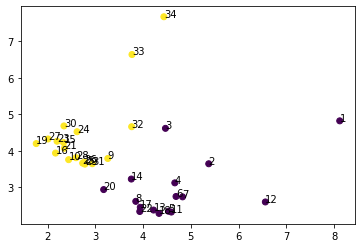

Cross Entropy Loss: = 0.038024548441171646


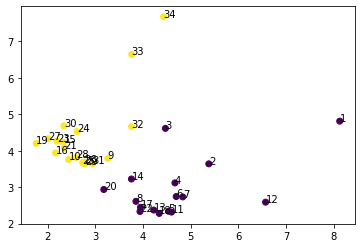

Cross Entropy Loss: = 0.037499282509088516


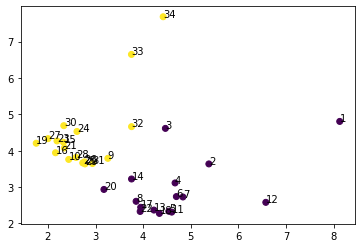

Cross Entropy Loss: = 0.036986663937568665


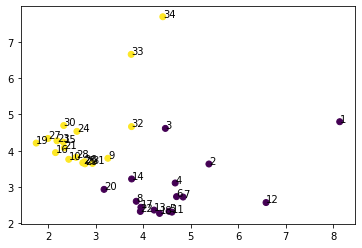

Cross Entropy Loss: = 0.0364861935377121


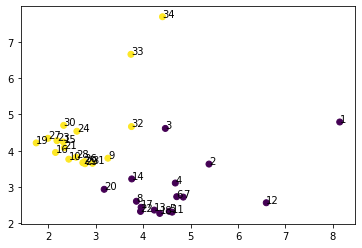

Cross Entropy Loss: = 0.0359974279999733


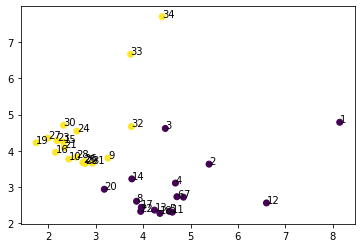

Cross Entropy Loss: = 0.03551999107003212


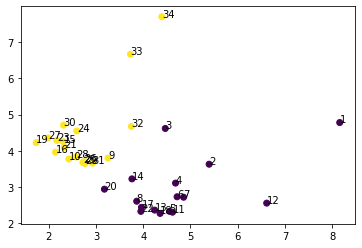

Cross Entropy Loss: = 0.035053543746471405


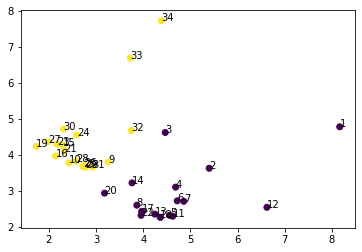

Cross Entropy Loss: = 0.03459770604968071


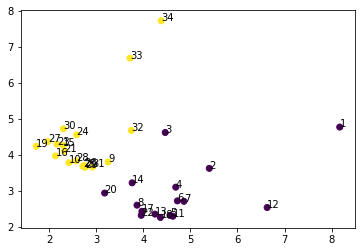

Cross Entropy Loss: = 0.034152429550886154


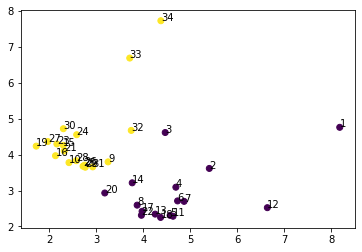

Cross Entropy Loss: = 0.033718887716531754


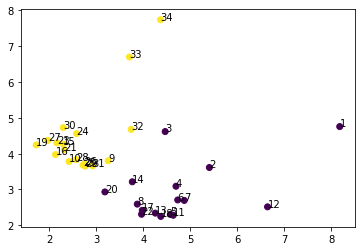

Cross Entropy Loss: = 0.033295128494501114


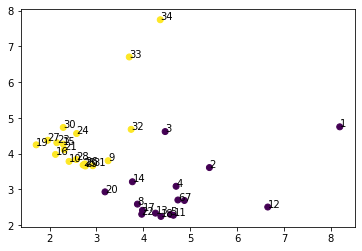

Cross Entropy Loss: = 0.03288070857524872


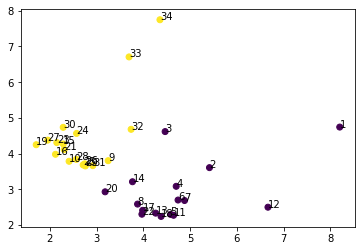

Cross Entropy Loss: = 0.032475464046001434


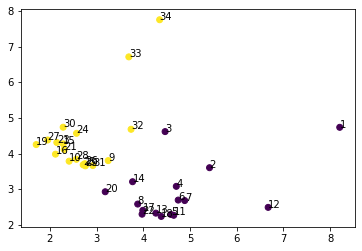

Cross Entropy Loss: = 0.032078880816698074


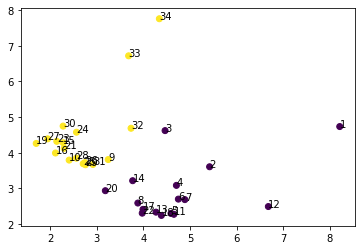

Cross Entropy Loss: = 0.031690921634435654


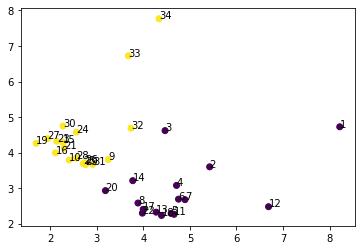

Cross Entropy Loss: = 0.03131112828850746


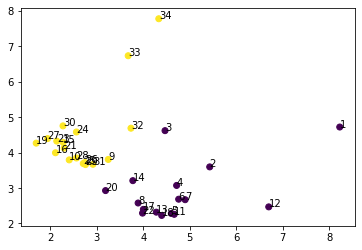

Cross Entropy Loss: = 0.03093939647078514


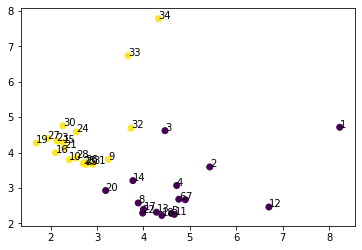

Cross Entropy Loss: = 0.030575504526495934


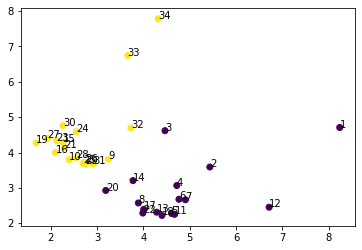

Cross Entropy Loss: = 0.030219055712223053


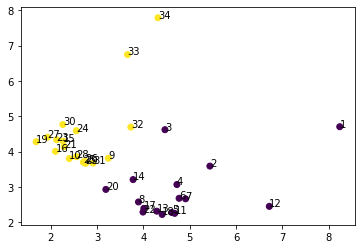

Cross Entropy Loss: = 0.02986999973654747


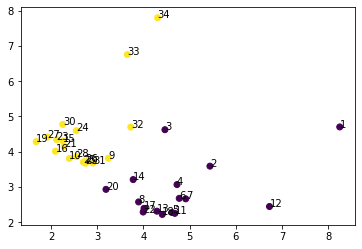

Cross Entropy Loss: = 0.02952793799340725


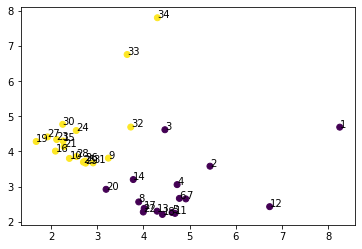

Cross Entropy Loss: = 0.029192939400672913


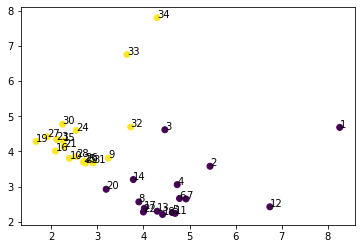

Cross Entropy Loss: = 0.028864484280347824


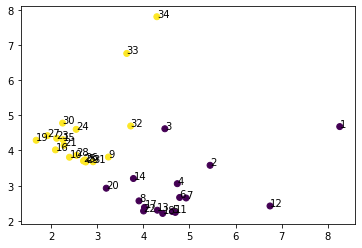

Cross Entropy Loss: = 0.02854258567094803


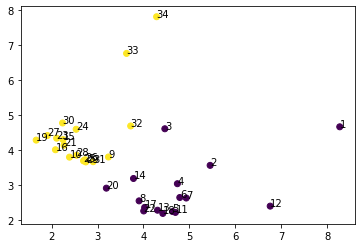

Cross Entropy Loss: = 0.02822701260447502


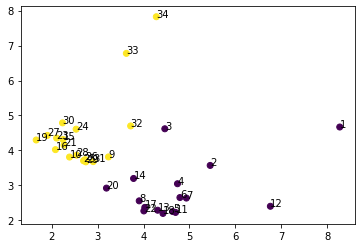

Cross Entropy Loss: = 0.027917660772800446


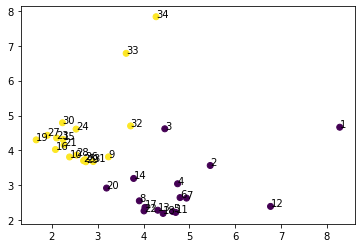

Cross Entropy Loss: = 0.027614183723926544


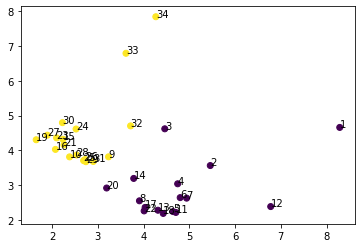

Cross Entropy Loss: = 0.02731652930378914


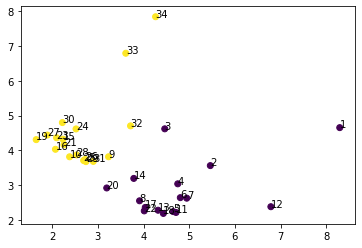

Cross Entropy Loss: = 0.027024585753679276


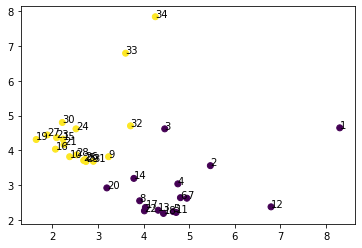

Cross Entropy Loss: = 0.02673807367682457


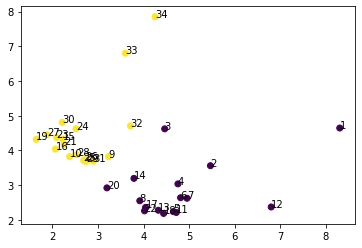

Cross Entropy Loss: = 0.026456991210579872


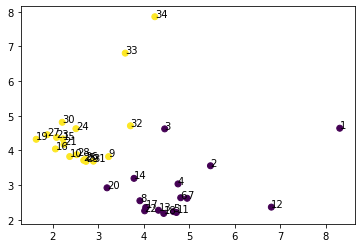

Cross Entropy Loss: = 0.026181112974882126


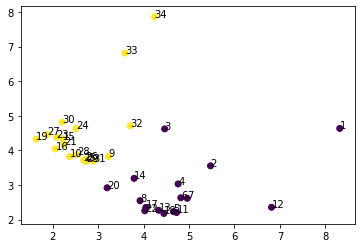

Cross Entropy Loss: = 0.025910213589668274


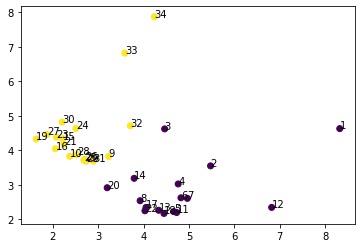

Cross Entropy Loss: = 0.025644350796937943


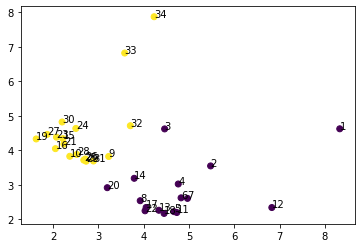

Cross Entropy Loss: = 0.02538324147462845


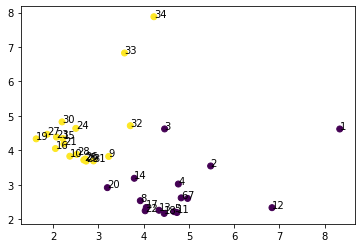

Cross Entropy Loss: = 0.02512688934803009


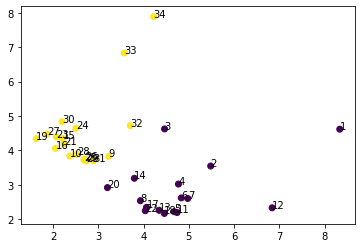

Cross Entropy Loss: = 0.024875005707144737


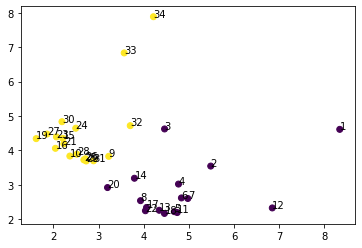

Cross Entropy Loss: = 0.02462770976126194


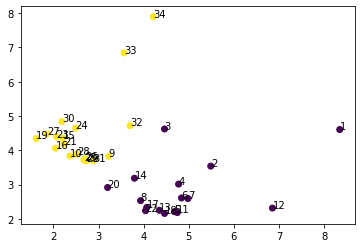

Cross Entropy Loss: = 0.02438465878367424


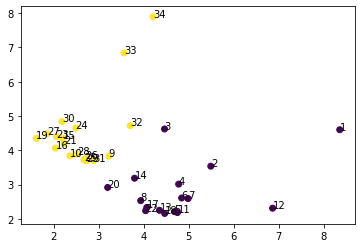

Cross Entropy Loss: = 0.024145908653736115


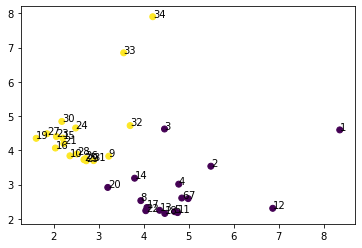

Cross Entropy Loss: = 0.023911237716674805


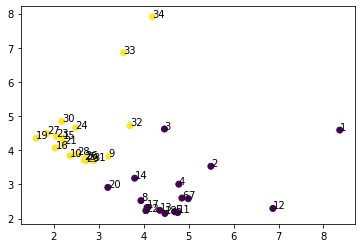

Cross Entropy Loss: = 0.023680582642555237


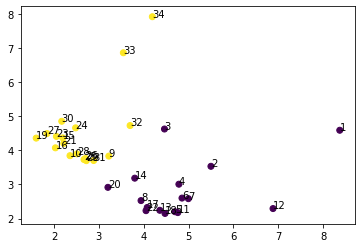

Cross Entropy Loss: = 0.02345389313995838


In [10]:

for i in range(200):
    
    optimizer.zero_grad()
    loss=criterion(T(X), target)
    loss.backward()
    optimizer.step()
    l=(T(X));
    if i%1==0:
        plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=[0, 0, 0, 0 ,0 ,0 ,0, 0, 1, 1, 0 ,0, 0, 0, 1 ,1 ,0 ,0 ,1, 0, 1, 0 ,1 ,1, 1, 1, 1 ,1 ,1, 1, 1, 1, 1, 1 ])
        for i in range(l.shape[0]):
            plt.text(l[i,0], l[i,1], str(i+1))
        plt.show()
        print("Cross Entropy Loss: =",loss.item())
    

As you can see above it has divided the data in two categories , and its close to the actual predictions. __TODO__ Actual labels.